## Forward-design 

In [1]:
import sys; sys.path.append('..')
import inflation, mesh, sheet_meshing
from tri_mesh_viewer import TriMeshViewer as Viewer
import triangulation
import numpy as np
import utils, py_newton_optimizer, benchmark

In [2]:
V, E = mesh.load_raw('data/ForwardDesign/hinge.obj')
fusedPts = list(np.loadtxt('data/ForwardDesign/fusehingev3.txt').reshape((-1, 2)))
holePts = []  # or load from file if you want, but it should be empty

In [3]:
m, iwv, iwbv = sheet_meshing.forward_design_mesh(V, E, fusedPts, holePts, np.prod(utils.bbox_dims(V)[0:2]) / 1e4)
isheet = inflation.InflatableSheet(m, iwv)

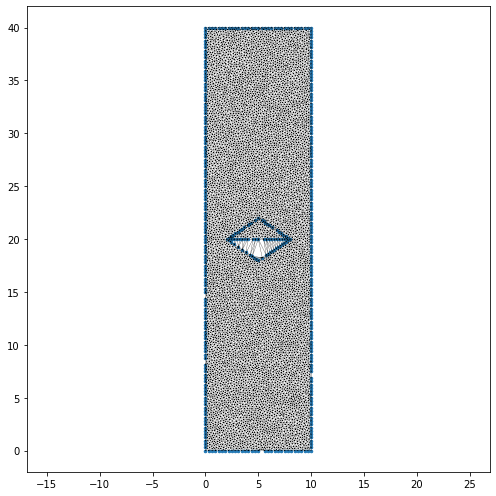

In [4]:
import visualization
visualization.plot_2d_mesh(m, pointList=np.where(iwv))

In [5]:
viewer = Viewer(isheet, wireframe=True)
viewer.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

InflatableSheet setVars	0.00438499	1
Newton iterations	81.0339	1
    InflatableSheet energy	0.000643015	1
    Newton iterate	81.0328	116
        Backtracking	0.619757	115
            InflatableSheet energy	0.110462	169
            InflatableSheet setVars	0.499425	169
        Compute descent direction	78.9512	115
            Negative curvature dir	0.222677	3
                negativeCurvatureDirection	0.214129	3
                    CHOLMOD Backsub	0.141868	51
                    CHOLMOD Numeric Factorize	0.00305676	3
                    CHOLMOD Symbolic Factorize	0.0335848	3
            newton_step	78.7275	115
                Newton solve	75.7975	195
                    CHOLMOD Numeric Factorize	73.6771	194
                    Solve	1.20246	116
                        CHOLMOD Backsub	1.03097	115
                        CHOLMOD Numeric Factorize	0.0213101	1
                        CHOLMOD Symbolic Factorize	0.132438	1
                hessEval	2.79648	115
                largestMagnitudeEi

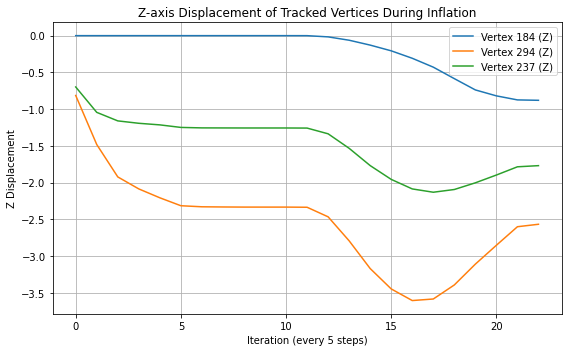

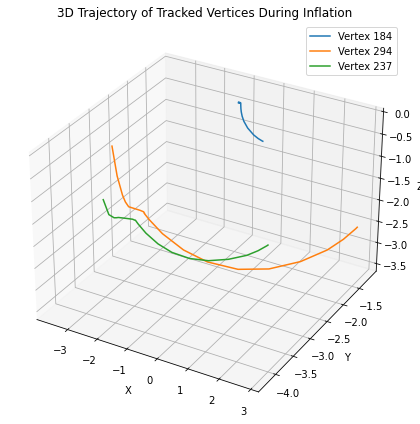

In [6]:
# ---- TRACKING SETUP ----
# Define vertices you want to track, using approximate (x, y, z) rest positions
target_points = np.array([
    [5.0,  0.0, 0.0],
    [5.0, 20.0, 0.0],
    [5.0, 40.0, 0.0]
])

# Find closest actual mesh vertices to those target positions
from scipy.spatial import KDTree
V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])
tree = KDTree(V_rest)
tracked_indices = [tree.query(p)[1] for p in target_points]

# Create dict to store trajectory per vertex
trajectory = {idx: [] for idx in tracked_indices}
framerate = 5  # Save every 5 iterations

def cb(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        viewer.update()

#Create the InflatableSheet and the Offscreen Viewer:
from tri_mesh_viewer import OffscreenTriMeshViewer
isheet = inflation.InflatableSheet(m, iwv)  # or use np.array(iwv) != 0 if needed
oview = OffscreenTriMeshViewer(isheet, width=768, height=640, wireframe=True)

# ---- RUN SIMULATION ----
import time
benchmark.reset()
oview.recordStart('tracked_inflationALL.mp4')  # Start video

isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)

opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.niter = 500
isheet.pressure = 1

cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)
benchmark.report()
oview.recordStop()  # End video

# ---- PLOT RESULTS: Z-axis Over Time ----
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 2], label=f"Vertex {idx} (Z)")

plt.xlabel("Iteration (every {} steps)".format(framerate))
plt.ylabel("Z Displacement")
plt.title("Z-axis Displacement of Tracked Vertices During Inflation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- PLOT 3D TRAJECTORIES ----
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D Trajectory of Tracked Vertices During Inflation")
ax.legend()
plt.tight_layout()
plt.show()


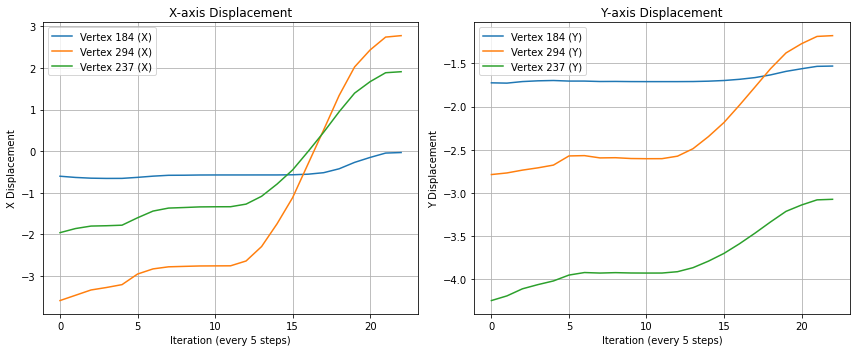

In [7]:
# Plot X and Y displacement
plt.figure(figsize=(12, 5))

# X Displacement
plt.subplot(1, 2, 1)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    plt.plot(range(len(traj)), traj[:, 0], label=f"Vertex {idx} (X)")
plt.xlabel("Iteration (every {} steps)".format(framerate))
plt.ylabel("X Displacement")
plt.title("X-axis Displacement")
plt.grid(True)
plt.legend()

# Y Displacement
plt.subplot(1, 2, 2)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    plt.plot(range(len(traj)), traj[:, 1], label=f"Vertex {idx} (Y)")
plt.xlabel("Iteration (every {} steps)".format(framerate))
plt.ylabel("Y Displacement")
plt.title("Y-axis Displacement")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


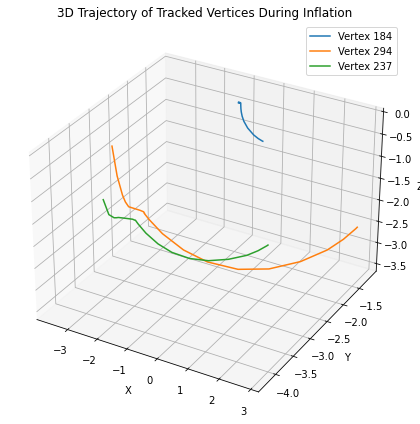

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D Trajectory of Tracked Vertices During Inflation")
ax.legend()
plt.tight_layout()
plt.show()


In [10]:
# Extract geometry from inflated sheet
V_raw, F_raw, *_ = isheet.visualizationGeometry()
V = np.array([v.flatten() for v in V_raw], dtype=np.float64)
F = np.array([f for f in F_raw], dtype=np.int32)


In [11]:
# Export inflated mesh to .obj
def write_obj(path, V, F):
    with open(path, "w") as f:
        for v in V:
            f.write("v {:.6f} {:.6f} {:.6f}\n".format(*v))
        for face in F:
            f.write("f {} {} {}\n".format(*(face + 1)))  # OBJ is 1-indexed

write_obj("inflated_scaledALL.obj", V, F)


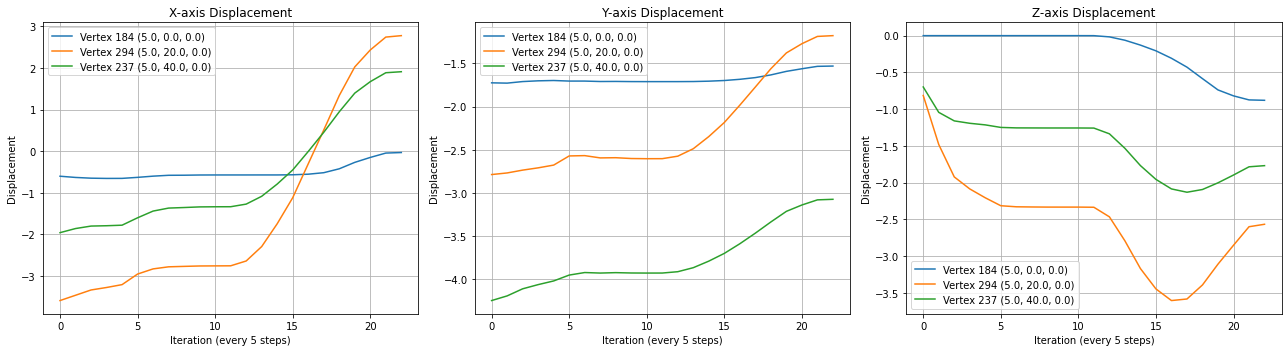

In [12]:

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
labels = [
    f"Vertex {idx} ({target_points[i][0]:.1f}, {target_points[i][1]:.1f}, {target_points[i][2]:.1f})"
    for i, idx in enumerate(tracked_indices)
]
for i, idx in enumerate(tracked_indices):
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    axs[0].plot(range(len(traj)), traj[:, 0], label=labels[i])
    axs[1].plot(range(len(traj)), traj[:, 1], label=labels[i])
    axs[2].plot(range(len(traj)), traj[:, 2], label=labels[i])
axs[0].set_title("X-axis Displacement")
axs[1].set_title("Y-axis Displacement")
axs[2].set_title("Z-axis Displacement")
for ax in axs:
    ax.set_xlabel("Iteration (every {} steps)".format(framerate))
    ax.set_ylabel("Displacement")
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()


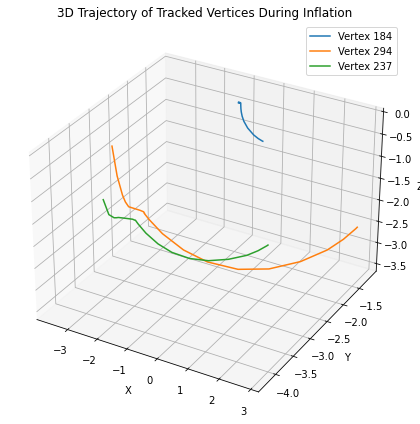

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D Trajectory of Tracked Vertices During Inflation")
ax.legend()
plt.tight_layout()
plt.show()